<!-- <img src='./pic/SharifUniLogo.png' alt="SUT logo" width=300 height=300 align=left class="saturate" > <br> -->

<div dir=ltr align=center>
<font color=0F5298 size=7>
    Big Data - Massive Data Mining <br>
<font color=696080 size=5>
     Frequent Trigram Mining with A-Priori and PCY <br>
<font color=696880 size=4>
    Mohammad Ali Etemadi Naeen
    
____

## **Install Pypark & Initialization**

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Apriori_PCY_Frequent_Trigram") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

your 131072x1 screen size is bogus. expect trouble
24/12/22 22:23:08 WARN Utils: Your hostname, LAPTOP-1NBL3U8Q resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/22 22:23:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/22 22:23:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os
import re
import json
import string
import random
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords

import hashlib
from hashlib import md5

from wordcloud import WordCloud
from collections import Counter
from itertools import combinations


## **Reading the data**

In [ ]:
arxiv_rdd = sc.textFile("/home/linux/BigData/Dataset/Arxiv-Dataset.json")

In [5]:
arxiv_rdd.take(10)

['{"id":"0704.0001","submitter":"Pavel Nadolsky","authors":"C. Bal\\\\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan","title":"Calculation of prompt diphoton production cross sections at Tevatron and\\n  LHC energies","comments":"37 pages, 15 figures; published version","journal-ref":"Phys.Rev.D76:013009,2007","doi":"10.1103/PhysRevD.76.013009","report-no":"ANL-HEP-PR-07-12","categories":"hep-ph","license":null,"abstract":"  A fully differential calculation in perturbative quantum chromodynamics is\\npresented for the production of massive photon pairs at hadron colliders. All\\nnext-to-leading order perturbative contributions from quark-antiquark,\\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\\nall-orders resummation of initial-state gluon radiation valid at\\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\\nspecified in which the calculation is most reliable. Good agreement is\\ndemonstrated with data from the Fermilab Tevatro

In [5]:
def extract_fields(rdd):
    # Parse the JSON strings & extract all fields
    all_fields = rdd.flatMap(lambda line: json.loads(line).keys()).distinct().collect()
    return all_fields

fields = extract_fields(arxiv_rdd)
print("Unique fields in the dataset:", fields)


Unique fields in the dataset: ['categories', 'title', 'doi', 'versions', 'submitter', 'license', 'authors', 'update_date', 'report-no', 'journal-ref', 'abstract', 'id', 'authors_parsed', 'comments']


In [7]:
print("count:", len(fields))

count: 14


## **Preprocessing**

In this section, we will clean the dataset by removing stop words and irrelevant characters to ensure the data is well-prepared for analysis.


### Part 1: Identify and remove or impute any null values, especially in critical fields

In [4]:
critical_fields = ['title', 'abstract']
# critical_fields = ['title', 'abstract', 'license']

# Convert String to Dict
arxiv_rdd_modify = arxiv_rdd.map(lambda record: json.loads(record))

In [5]:
arxiv_rdd_modify.take(5)


[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

##### Remove

In [6]:
# removed_rdd = arxiv_rdd_modify.filter(
#     lambda record: all(record.get(field) is not None for field in critical_fields)
# )

# print("Count after removing nulls:", removed_rdd.count())

In [7]:
# removed_rdd.take(2)

##### Imute

In [8]:
default_values = {
    # 'id': 'unknown_id',
    'title': 'unknown_title',
    'abstract': 'unknown_abstract',
    # 'license': 'unknown_license'
}


In [9]:
imputed_rdd = arxiv_rdd_modify.map(
    lambda record: {
        field: (record.get(field) if record.get(field) is not None else default_values.get(field, 'unknown'))
        for field in record
    }
)

imputed_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated w

### Part 2: find and remove stopwords

In [10]:
# stopwords = {
#     "the", "and", "of", "to", "in", "a", "is", "for", "on", "with", "as", "by",
#     "an", "be", "are", "this", "that", "it", "from", "at", "or", "which", "we",
#     "these", "not", "but", "also", "has", "was", "will", "were", "can", "have",
#     "our", "its", "their"
# }

def remove_stopwords(text, stopwords):

    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]

    return ' '.join(filtered_words)


In [11]:
nltk.download('stopwords')
stopwords_english = stopwords.words('english')

# Remove stopwords
no_stopwords_rdd = imputed_rdd.map(lambda record: {
    **record,
    'title': remove_stopwords(record.get('title', ''), stopwords_english),
    'abstract': remove_stopwords(record.get('abstract', ''), stopwords_english)
})


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [12]:
no_stopwords_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation prompt diphoton production cross sections Tevatron LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': 'fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders. next-to-leading order perturbative contributions quark-antiquark, gluon-(anti)quark, gluon-gluon subprocesses included, well all-orders resummation initial-state gluon radiation valid next-to-next-to-leading logarithmic accuracy. region phase space specified calculation reliable. Good agreement demonstrated data Fermilab Tevatron, predictions made detailed tests CDF data. Predictions shown distributions diphoton p

### Part 3: find and remove useless characters

In [13]:
def clean_dataset_text(text):

    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)

    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()

    return text


cleaned_rdd = no_stopwords_rdd.map(lambda record: {
    **record,
    'title': clean_dataset_text(record.get('title', '')),
    'abstract': clean_dataset_text(record.get('abstract', ''))
})

cleaned_rdd.take(3)

[{'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'calculation prompt diphoton production cross sections tevatron lhc energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': 'unknown',
  'abstract': 'fully differential calculation perturbative quantum chromodynamics presented production massive photon pairs hadron colliders nexttoleading order perturbative contributions quarkantiquark gluonantiquark gluongluon subprocesses included well allorders resummation initialstate gluon radiation valid nexttonexttoleading logarithmic accuracy region phase space specified calculation reliable good agreement demonstrated data fermilab tevatron predictions made detailed tests cdf data predictions shown distributions diphoton pairs produced energy 

## **Count Frequent Trigram using A-Priori & PCY Algorithms**

### **I. Counting Frequent Trigrams in Order (Consecutive Words)**

#### 1: A-Priori

##### *Algorithm Code*

In [20]:
# Extract abstracts and tokenize them
tokenized_abstracts_rdd = cleaned_rdd.map(lambda record: record['abstract'].split())

# Generate trigrams for each abstract
trigrams_rdd = tokenized_abstracts_rdd.flatMap(
    lambda tokens: [' '.join(tokens[i:i+3]) for i in range(len(tokens) - 2)]
)

# Count occurrences of each trigram
trigram_counts_rdd = trigrams_rdd.map(lambda trigram: (trigram, 1)).reduceByKey(lambda x, y: x + y)

# Filter trigrams based on minimum support
min_support = 100
frequent_trigrams_rdd = trigram_counts_rdd.filter(lambda x: x[1] >= min_support)

# Collect results
top_trigrams = frequent_trigrams_rdd.takeOrdered(10, key=lambda x: -x[1])

# Display results
print("Top Frequent Trigrams:")
for trigram, count in top_trigrams:
    print(f"{trigram}: {count}")


Top Frequent Trigrams:
large language models: 19669
deep neural networks: 15863
density functional theory: 13603
language models llms: 13568
experimental results show: 13135
convolutional neural networks: 11749
monte carlo simulations: 11390
convolutional neural network: 10752
natural language processing: 10368
cosmic microwave background: 9885


In [21]:
frequent_trigrams_rdd.take(5)

[('graphs partial cubes', 7),
 ('manifold lie group', 28),
 ('matsubara green function', 11),
 ('symmetry breaking nucleon', 14),
 ('steady states general', 7)]

In [22]:
top_trigrams

[('large language models', 19669),
 ('deep neural networks', 15863),
 ('density functional theory', 13603),
 ('language models llms', 13568),
 ('experimental results show', 13135),
 ('convolutional neural networks', 11749),
 ('monte carlo simulations', 11390),
 ('convolutional neural network', 10752),
 ('natural language processing', 10368),
 ('cosmic microwave background', 9885)]

##### *Display Results*

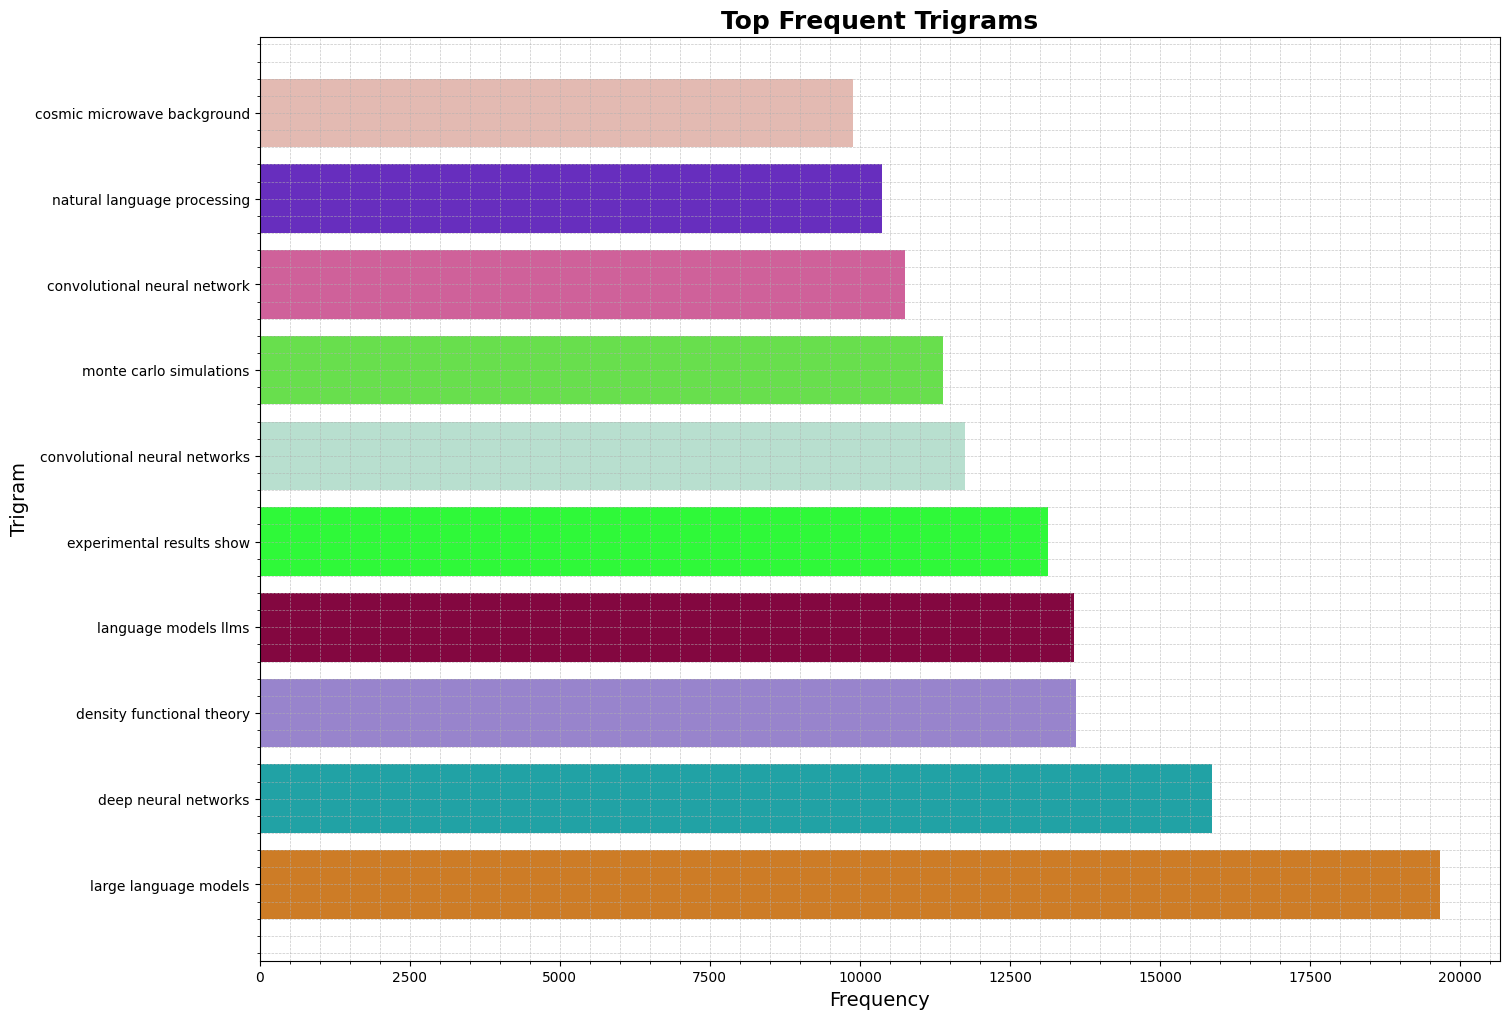

In [23]:
colors = [f"#{''.join([random.choice('0123456789ABCDEF') for _ in range(6)])}" for _ in top_trigrams]

plt.figure(figsize=(16, 12))
labels, values = zip(*top_trigrams)
plt.barh(labels, values, color=colors)  
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Trigram", fontsize=14)
plt.title("Top Frequent Trigrams", fontsize=18, fontweight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()
plt.show()


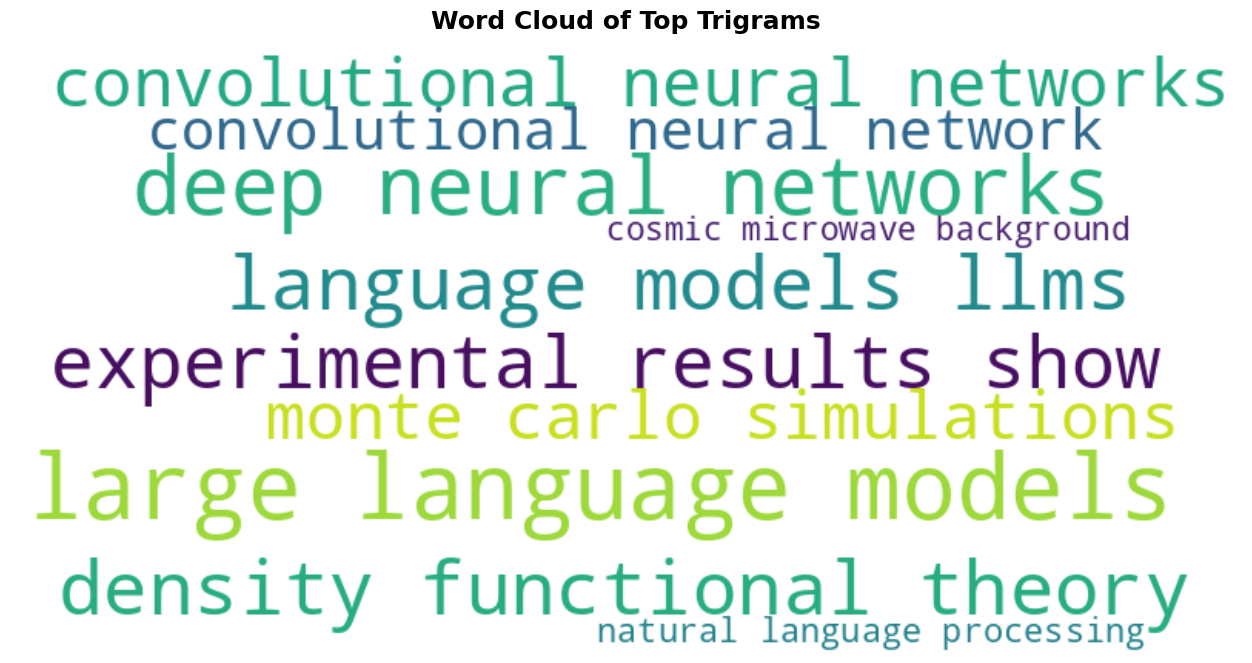

In [26]:
trigram_dict = dict(top_trigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_dict)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top Trigrams", fontsize=18, fontweight='bold')
plt.show()


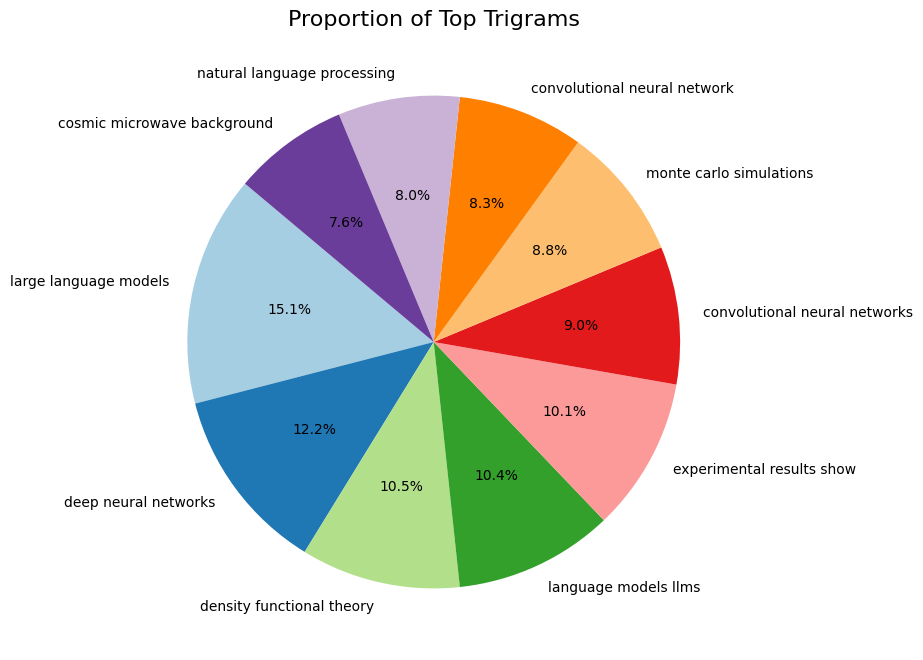

In [27]:
plt.figure(figsize=(10, 8))
labels, values = zip(*top_trigrams)
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Proportion of Top Trigrams", fontsize=16)
plt.show()


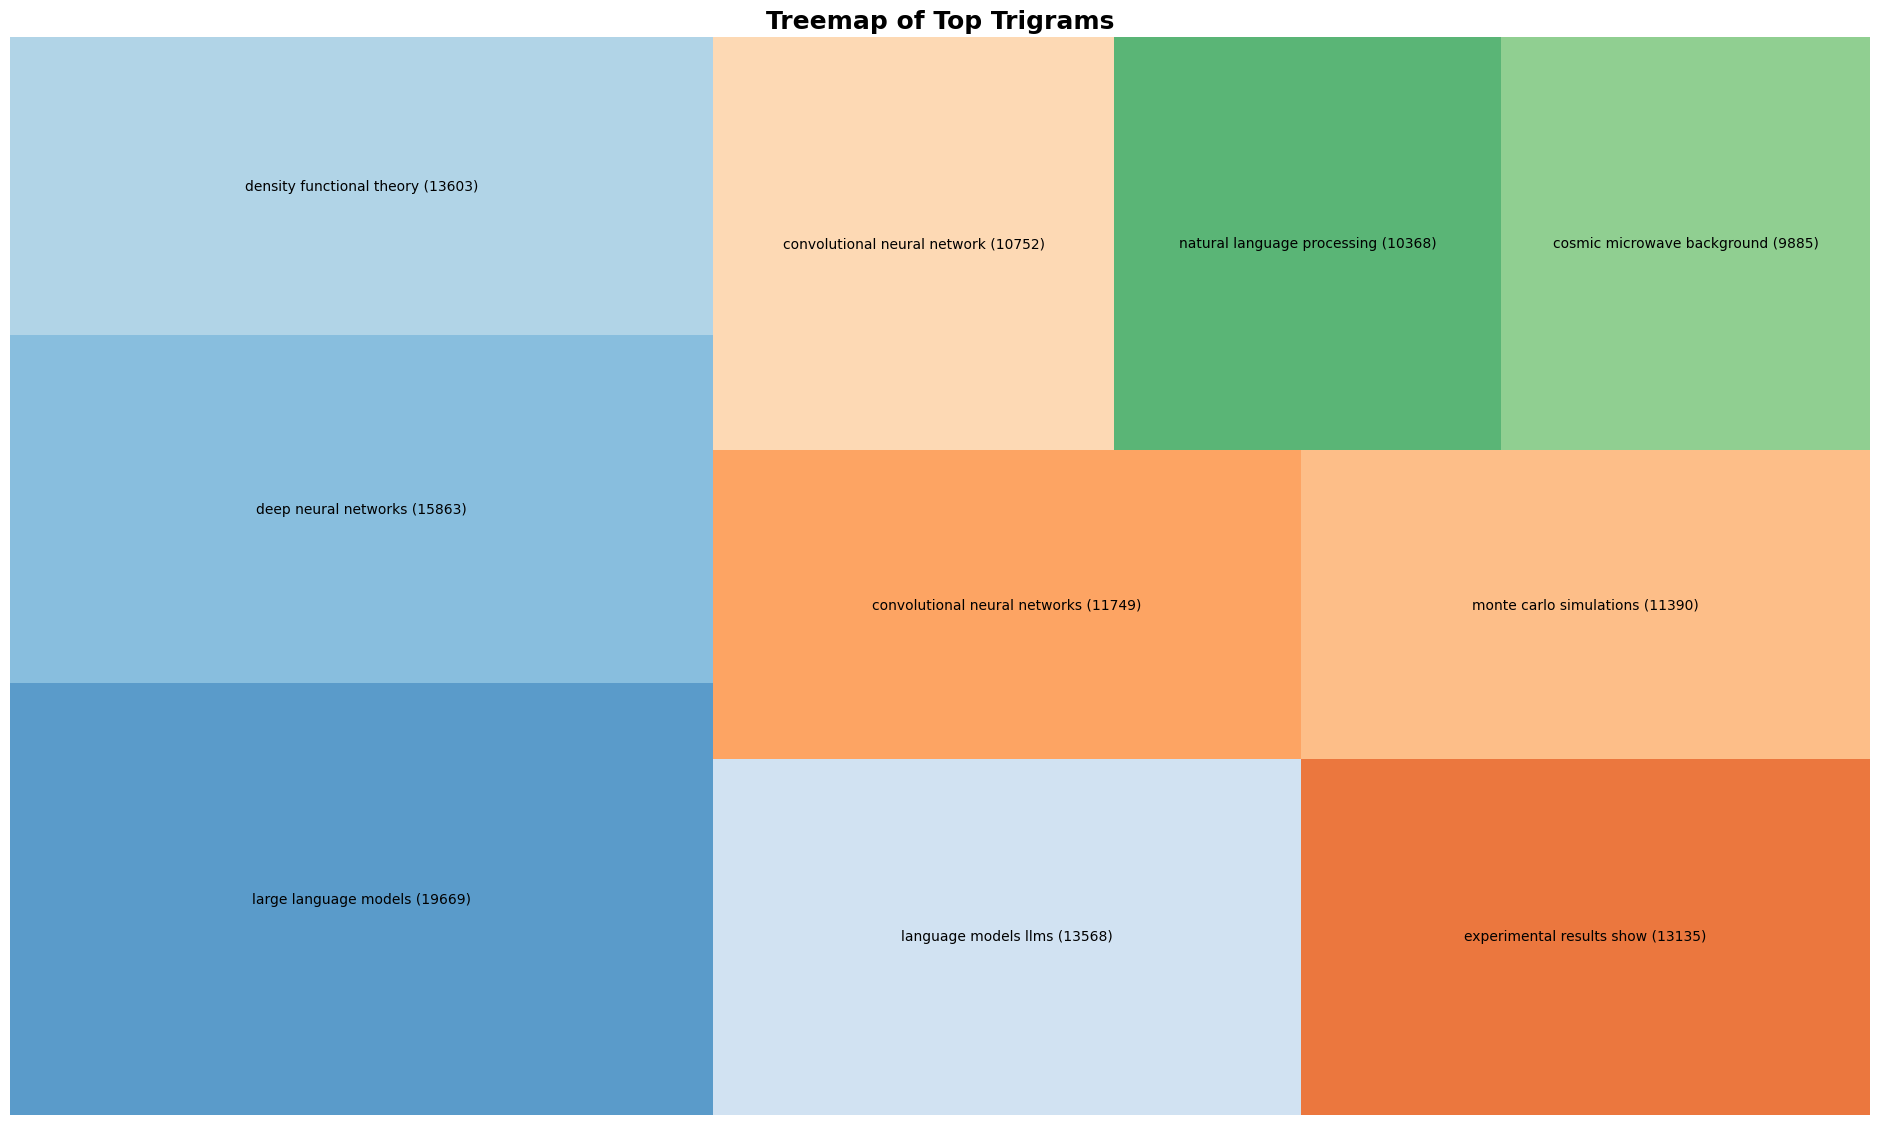

In [28]:
labels = [f"{t[0]} ({t[1]})" for t in top_trigrams]
sizes = [t[1] for t in top_trigrams]

plt.figure(figsize=(24, 14))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.tab20c.colors)
plt.axis('off')
plt.title("Treemap of Top Trigrams", fontsize=18, fontweight='bold')
plt.show()


#### 2: PCY

##### *Algorithm Code*

In [46]:
# Tokenize abstracts
tokenized_rdd = cleaned_rdd.map(lambda record: record["abstract"].split())

# Generate all possible trigrams
trigrams_rdd = tokenized_rdd.flatMap(lambda words: 
                                     [" ".join(trigram) for trigram in zip(words, words[1:], words[2:])])

# First Pass - Count Trigrams and Hash to Buckets
bucket_size = 1000  
threshold = 10  
# bucket_size = 2000  
# threshold = 5 

# Hash function for buckets
def hash_trigram(trigram):
    return int(hashlib.md5(trigram.encode()).hexdigest(), 16) % bucket_size

# Count trigrams and hash to buckets
trigram_counts = trigrams_rdd.map(lambda trigram: (trigram, 1)).reduceByKey(lambda x, y: x + y)
bucket_counts = trigrams_rdd.map(lambda trigram: (hash_trigram(trigram), 1)).reduceByKey(lambda x, y: x + y)

# Create Bitmap
frequent_buckets = bucket_counts.filter(lambda x: x[1] >= threshold).map(lambda x: x[0]).collect()
bitmap = set(frequent_buckets)

# Second Pass - Filter and Count Frequent Trigrams
frequent_trigrams = trigram_counts.filter(lambda x: hash_trigram(x[0]) in bitmap and x[1] >= threshold)

# Collect Results
top_frequent_trigrams = frequent_trigrams.takeOrdered(10, key=lambda x: -x[1])

# Display Results
print("Top Frequent Trigrams:")
for trigram, count in top_frequent_trigrams:
    print(f"{trigram}: {count}")



Top Frequent Trigrams:
large language models: 19669
deep neural networks: 15863
density functional theory: 13603
language models llms: 13568
experimental results show: 13135
convolutional neural networks: 11749
monte carlo simulations: 11390
convolutional neural network: 10752
natural language processing: 10368
cosmic microwave background: 9885


In [47]:
frequent_trigrams.take(3)

[('manifold lie group', 28),
 ('matsubara green function', 11),
 ('symmetry breaking nucleon', 14)]

In [48]:
top_frequent_trigrams

[('large language models', 19669),
 ('deep neural networks', 15863),
 ('density functional theory', 13603),
 ('language models llms', 13568),
 ('experimental results show', 13135),
 ('convolutional neural networks', 11749),
 ('monte carlo simulations', 11390),
 ('convolutional neural network', 10752),
 ('natural language processing', 10368),
 ('cosmic microwave background', 9885)]

##### *Display Results*

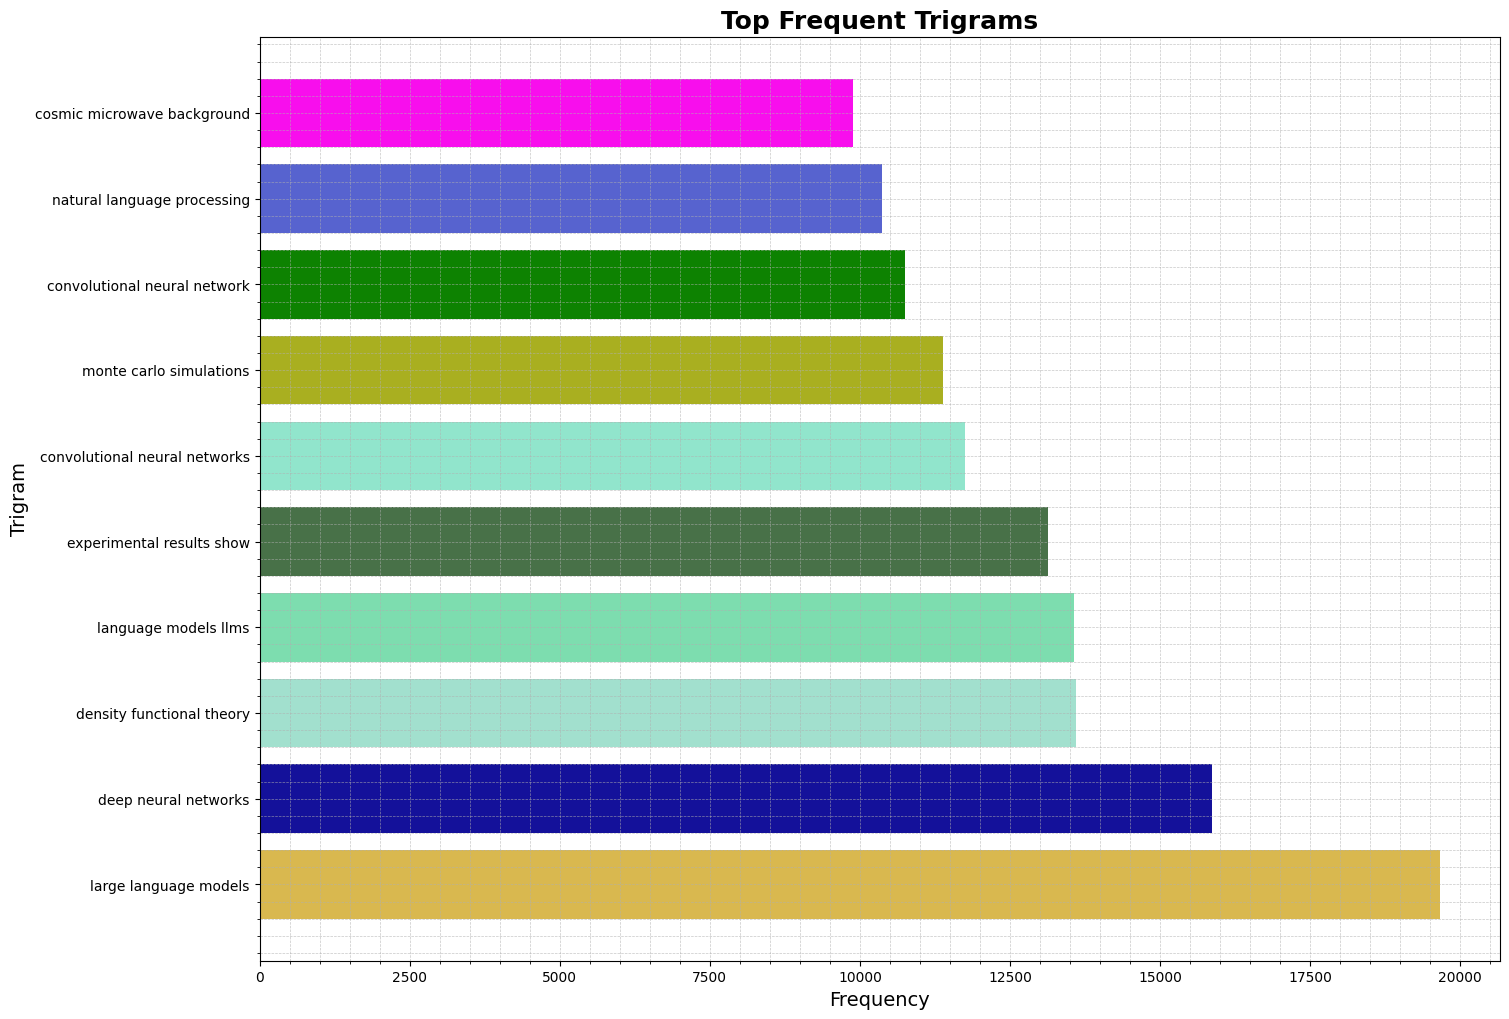

In [50]:
colors = [f"#{''.join([random.choice('0123456789ABCDEF') for _ in range(6)])}" for _ in top_frequent_trigrams]

plt.figure(figsize=(16, 12))
labels, values = zip(*top_frequent_trigrams)
plt.barh(labels, values, color=colors)  
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Trigram", fontsize=14)
plt.title("Top Frequent Trigrams", fontsize=18, fontweight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()
plt.show()


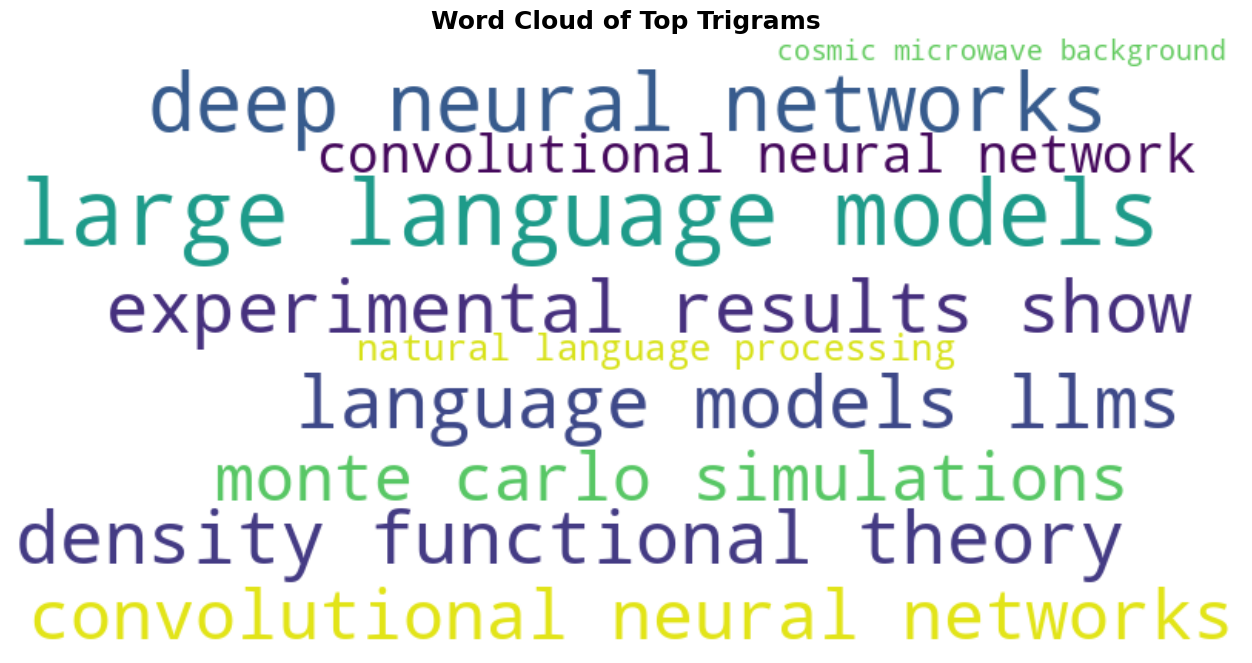

In [51]:
trigram_dict = dict(top_frequent_trigrams)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_dict)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top Trigrams", fontsize=18, fontweight='bold')
plt.show()


#### 3: Jaccard

##### First Try

In [52]:
pcy_results = frequent_trigrams.map(lambda x: x[0]).collect()

In [53]:
apriori_results = frequent_trigrams_rdd.map(lambda x: x[0]).collect()

In [54]:
pcy_frequent_trigrams = set(pcy_results) 
apriori_frequent_trigrams = set(apriori_results)  

# True Positives (TP), False Positives (FP), and False Negatives (FN)
true_positives = pcy_frequent_trigrams.intersection(apriori_frequent_trigrams)
false_positives = pcy_frequent_trigrams - apriori_frequent_trigrams
false_negatives = apriori_frequent_trigrams - pcy_frequent_trigrams

# Jaccard Calculation
jaccard_index = len(true_positives) / len(pcy_frequent_trigrams.union(apriori_frequent_trigrams))

print(f"True Positives (TP): {len(true_positives)}")
print(f"False Positives (FP): {len(false_positives)}")
print(f"False Negatives (FN): {len(false_negatives)}")
print(f"Jaccard Index: {jaccard_index:.4f}")


True Positives (TP): 944969
False Positives (FP): 0
False Negatives (FN): 1944128
Jaccard Index: 0.3271


##### Second Try

Achieving a Jaccard Index of more than 0.5 is my goal here, because I want the PCY algorithm to align more closely with the results of A-Priori.There are some potential strategies to improve the Jaccard Index:

---

**1. Tune Threshold and Bucket Size**  
The choice of `threshold` and `bucket_size` significantly impacts the PCY algorithm's performance. 

- **Threshold:** Lowering the frequency threshold could reduce False Negatives (trigrams identified by A-Priori but missed by PCY). However, this might increase computational costs.  
- **Bucket Size:** Increasing the number of buckets reduces collisions in the hash map, leading to more accurate filtering during the second pass.  

---

**2. Advanced Hashing Techniques**  
The hash function used to assign trigrams to buckets plays a critical role. We can experiment with:
- **Double Hashing:** Use two hash functions to minimize collisions.  
- **Hashing with Random Seeds:** Randomize the hash function for more even distribution.  

---

**3. Implement PCY Extensions**  
We can use PCY extensions which are designed to improve accuracy:  
- **Multistage PCY:** Use multiple hash tables to filter out candidates progressively.  
- **Multihash PCY:** Use multiple independent hash functions for the same bucket pass, further reducing hash collisions.  

    These approaches will require more memory but can significantly reduce False Negatives.
---

I used the First Strategy, Tuning the *Threshold* and *Bucket Size*, to achieve a higher Jaccard Index, ideally above 0.5, while maintaining PCY's efficiency advantages. So, I reduced the threshold which is not very crucial in this code. But more important approach was increasing the bucket size. I increased the Bucket size from 1000 to 2000. Using more buckets, reduces collisions in the hash map, leading to more accurate filtering

In [55]:
# Tokenize abstracts
tokenized_rdd = cleaned_rdd.map(lambda record: record["abstract"].split())

# Generate all possible trigrams
trigrams_rdd = tokenized_rdd.flatMap(lambda words: 
                                     [" ".join(trigram) for trigram in zip(words, words[1:], words[2:])])

# First Pass - Count Trigrams and Hash to Buckets
bucket_size = 2000  # Number of buckets for hashing
threshold = 5  # Frequency threshold

# Hash function for buckets
def hash_trigram(trigram):
    return int(hashlib.md5(trigram.encode()).hexdigest(), 16) % bucket_size

# Count trigrams and hash to buckets
trigram_counts = trigrams_rdd.map(lambda trigram: (trigram, 1)).reduceByKey(lambda x, y: x + y)
bucket_counts = trigrams_rdd.map(lambda trigram: (hash_trigram(trigram), 1)).reduceByKey(lambda x, y: x + y)

# Create Bitmap
frequent_buckets = bucket_counts.filter(lambda x: x[1] >= threshold).map(lambda x: x[0]).collect()
bitmap = set(frequent_buckets)

# Second Pass - Filter and Count Frequent Trigrams
frequent_trigrams = trigram_counts.filter(lambda x: hash_trigram(x[0]) in bitmap and x[1] >= threshold)

# Collect Results
top_frequent_trigrams = frequent_trigrams.takeOrdered(10, key=lambda x: -x[1])

# Display Results
print("Top Frequent Trigrams:")
for trigram, count in top_frequent_trigrams:
    print(f"{trigram}: {count}")



Top Frequent Trigrams:
large language models: 19669
deep neural networks: 15863
density functional theory: 13603
language models llms: 13568
experimental results show: 13135
convolutional neural networks: 11749
monte carlo simulations: 11390
convolutional neural network: 10752
natural language processing: 10368
cosmic microwave background: 9885


In [56]:
pcy_results = frequent_trigrams.map(lambda x: x[0]).collect()

In [57]:
apriori_results = frequent_trigrams_rdd.map(lambda x: x[0]).collect()

In [58]:
pcy_frequent_trigrams = set(pcy_results)  
apriori_frequent_trigrams = set(apriori_results)  

# True Positives (TP), False Positives (FP), and False Negatives (FN)
true_positives = pcy_frequent_trigrams.intersection(apriori_frequent_trigrams)
false_positives = pcy_frequent_trigrams - apriori_frequent_trigrams
false_negatives = apriori_frequent_trigrams - pcy_frequent_trigrams

# Jaccard Calculation
jaccard_index = len(true_positives) / len(pcy_frequent_trigrams.union(apriori_frequent_trigrams))

print(f"True Positives (TP): {len(true_positives)}")
print(f"False Positives (FP): {len(false_positives)}")
print(f"False Negatives (FN): {len(false_negatives)}")
print(f"Jaccard Index: {jaccard_index:.4f}")


True Positives (TP): 2889097
False Positives (FP): 0
False Negatives (FN): 0
Jaccard Index: 1.0000


So as the results shows, increasing the bucket size, not only results in reducing the False Negatives to 0, but also we achived the jaccard Index equal to 1 which is the ideal :)

---

### **II. Counting Frequent Trigrams in Any Order (Non-Consecutive, Unordered Words)**

#### **Apriori - New**

##### A) Apriori on ***article's abstract texts***

###### 70% of the Data

In [17]:
# Sample the dataset
subset_fraction = 0.7
seed = 42  
sampled_abstracts = cleaned_rdd.sample(False, subset_fraction, seed)

# Define thresholds for support
support_thresholds = {
    "singletons": 100000,
    "pairs": 60000,
    "triples": 20000
}

def tokenize_text(record):
    return record.get("abstract", "").split()

def filter_frequent_items(items, threshold):
    return (
        items.map(lambda item: (item, 1))
        .reduceByKey(lambda x, y: x + y)
        .filter(lambda x: x[1] >= threshold)
    )

def generate_combinations(tokens, size):
    unique_tokens = list(set(tokens))
    return [comb for comb in combinations(sorted(unique_tokens), size)]

def validate_combinations(combination, previous_frequent_sets):
    subsets = combinations(combination, len(combination) - 1)
    return all(tuple(sorted(subset)) in previous_frequent_sets for subset in subsets)

# frequent singletons 
tokens_rdd = sampled_abstracts.flatMap(tokenize_text)
frequent_singletons = filter_frequent_items(tokens_rdd, support_thresholds["singletons"])
frequent_singleton_items = set(frequent_singletons.map(lambda x: x[0]).collect())

# frequent pairs 
def process_pairs(record):
    tokens = [token for token in tokenize_text(record) if token in frequent_singleton_items]
    return generate_combinations(tokens, 2)

pairs_rdd = sampled_abstracts.flatMap(process_pairs)
frequent_pairs = filter_frequent_items(pairs_rdd, support_thresholds["pairs"])
frequent_pair_items = set(frequent_pairs.map(lambda x: x[0]).collect())

# frequent triples
def process_triples(record):
    tokens = [token for token in tokenize_text(record) if token in frequent_singleton_items]
    return [
        triple for triple in generate_combinations(tokens, 3)
        if validate_combinations(triple, frequent_pair_items)
    ]

triples_rdd = sampled_abstracts.flatMap(process_triples)
frequent_triples = filter_frequent_items(triples_rdd, support_thresholds["triples"])

# Collect and display results 
print("Frequent 3-Itemsets:")
for triple, count in frequent_triples.collect():
    print(f"{triple}: {count}")


Frequent 3-Itemsets:


('based', 'method', 'model'): 25730
('model', 'present', 'show'): 23049
('approach', 'paper', 'using'): 25129
('also', 'data', 'different'): 20684
('model', 'proposed', 'results'): 28524
('approach', 'paper', 'show'): 21433
('paper', 'results', 'two'): 31837
('data', 'however', 'show'): 20776
('approach', 'data', 'method'): 20850
('model', 'paper', 'proposed'): 30023
('models', 'paper', 'results'): 25314
('approach', 'data', 'model'): 28952
('data', 'methods', 'paper'): 22864
('analysis', 'model', 'results'): 22261
('also', 'present', 'results'): 30602
('one', 'paper', 'show'): 22677
('also', 'data', 'used'): 21323
('also', 'results', 'time'): 22267
('find', 'results', 'using'): 21468
('results', 'show', 'using'): 48448
('however', 'results', 'using'): 24576
('based', 'paper', 'two'): 21986
('propose', 'proposed', 'using'): 20615
('approach', 'model', 'results'): 27870
('however', 'model', 'using'): 25048
('data', 'large', 'results'): 20730
('also', 'find', 'study'): 21734
('model', 'r

In [19]:
sorted_frequent_triples = (frequent_triples.collect())

sorted_frequent_triples = sorted(
    sorted_frequent_triples,
    key=lambda x: (-x[1], x[0])
)

print("Sorted Frequent 3-Itemsets:")
for triple, count in sorted_frequent_triples:
    print(f"{triple}: {count}")


Sorted Frequent 3-Itemsets:
('also', 'results', 'show'): 51751
('data', 'model', 'models'): 50324
('model', 'results', 'show'): 48602
('results', 'show', 'using'): 48448
('model', 'results', 'using'): 47797
('data', 'model', 'using'): 46898
('paper', 'results', 'show'): 46604
('model', 'models', 'results'): 45926
('model', 'models', 'using'): 45217
('data', 'model', 'results'): 43122
('also', 'results', 'using'): 42967
('model', 'models', 'show'): 42786
('data', 'results', 'using'): 42425
('also', 'model', 'results'): 41864
('also', 'model', 'show'): 41356
('also', 'model', 'models'): 40948
('also', 'show', 'using'): 40327
('model', 'show', 'using'): 40250
('also', 'model', 'using'): 39295
('results', 'show', 'two'): 39183
('also', 'paper', 'results'): 38651
('model', 'models', 'paper'): 38486
('model', 'paper', 'results'): 37997
('paper', 'results', 'using'): 37585
('also', 'paper', 'show'): 37437
('data', 'results', 'show'): 36799
('also', 'show', 'two'): 36584
('model', 'results', '

In [24]:
sorted_frequent_triples

[(('also', 'results', 'show'), 51751),
 (('data', 'model', 'models'), 50324),
 (('model', 'results', 'show'), 48602),
 (('results', 'show', 'using'), 48448),
 (('model', 'results', 'using'), 47797),
 (('data', 'model', 'using'), 46898),
 (('paper', 'results', 'show'), 46604),
 (('model', 'models', 'results'), 45926),
 (('model', 'models', 'using'), 45217),
 (('data', 'model', 'results'), 43122),
 (('also', 'results', 'using'), 42967),
 (('model', 'models', 'show'), 42786),
 (('data', 'results', 'using'), 42425),
 (('also', 'model', 'results'), 41864),
 (('also', 'model', 'show'), 41356),
 (('also', 'model', 'models'), 40948),
 (('also', 'show', 'using'), 40327),
 (('model', 'show', 'using'), 40250),
 (('also', 'model', 'using'), 39295),
 (('results', 'show', 'two'), 39183),
 (('also', 'paper', 'results'), 38651),
 (('model', 'models', 'paper'), 38486),
 (('model', 'paper', 'results'), 37997),
 (('paper', 'results', 'using'), 37585),
 (('also', 'paper', 'show'), 37437),
 (('data', 'resu

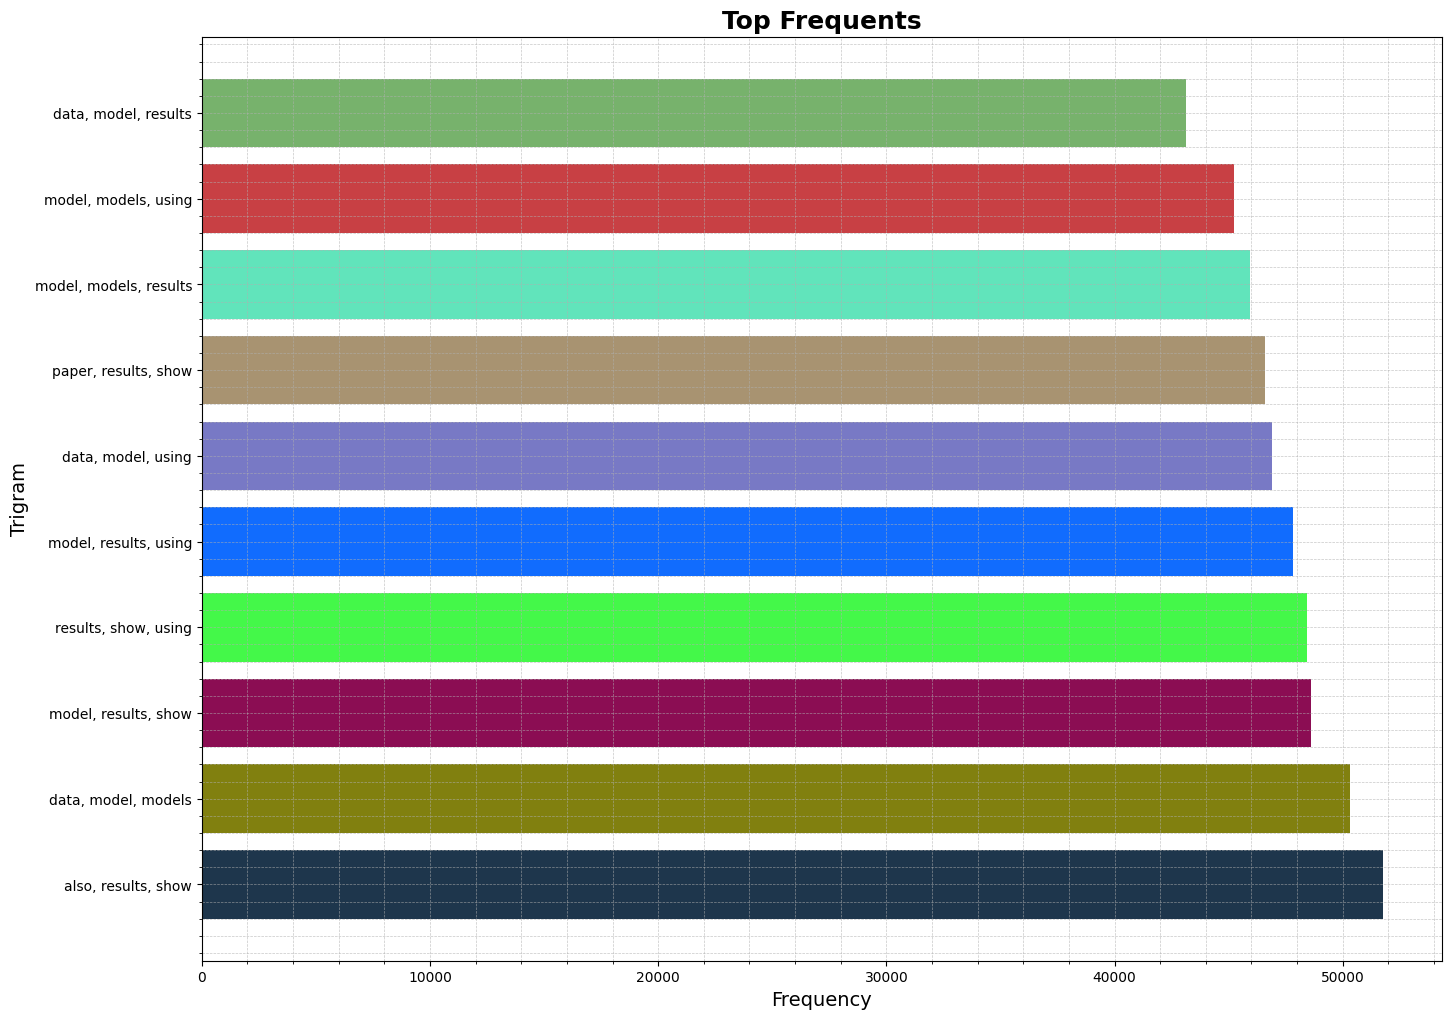

In [44]:
top_k = 10
top_frequent_triples = sorted_frequent_triples[:top_k]

labels = [", ".join(triple) for triple, _ in top_frequent_triples]
values = [count for _, count in top_frequent_triples]

colors = [f"#{''.join([random.choice('0123456789ABCDEF') for _ in range(6)])}" for _ in sorted_frequent_triples]

plt.figure(figsize=(16, 12))
plt.barh(labels, values, color=colors) 
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Trigram", fontsize=14)
plt.title("Top Frequents", fontsize=18, fontweight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()
plt.show()


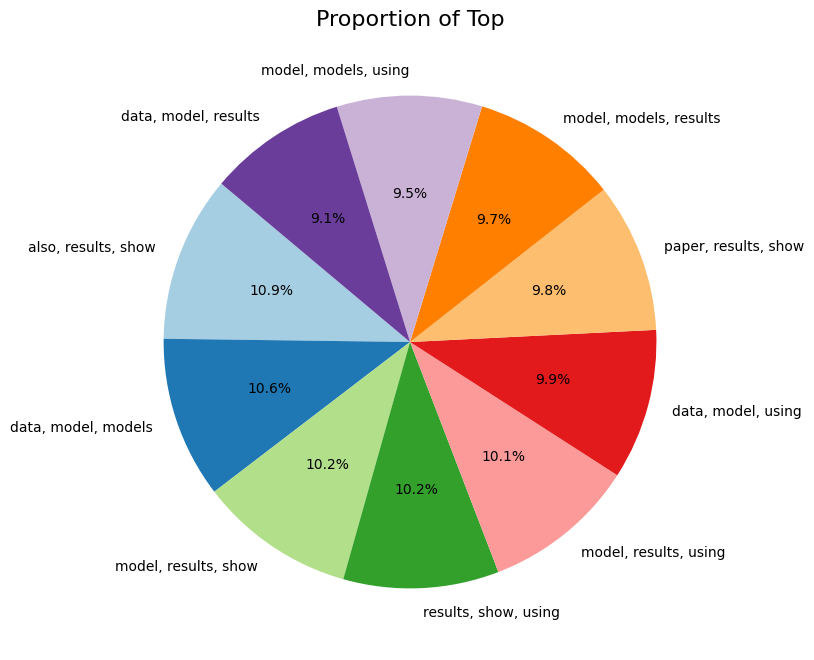

In [45]:
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Proportion of Top", fontsize=16)
plt.show()


###### 100% of the Data 

In [34]:
# Define thresholds for support 
support_thresholds = {
    "singletons": 100000,
    "pairs": 60000,
    "triples": 20000
}

def tokenize_text(record):
    return record.get("abstract", "").split()

def filter_frequent_items(items, threshold):
    return (
        items.map(lambda item: (item, 1))
        .reduceByKey(lambda x, y: x + y)
        .filter(lambda x: x[1] >= threshold)
    )

def generate_combinations(tokens, size):
    unique_tokens = list(set(tokens))
    return [comb for comb in combinations(sorted(unique_tokens), size)]

def validate_combinations(combination, previous_frequent_sets):
    subsets = combinations(combination, len(combination) - 1)
    return all(tuple(sorted(subset)) in previous_frequent_sets for subset in subsets)

# frequent singletons
tokens_rdd = cleaned_rdd.flatMap(tokenize_text)
frequent_singletons = filter_frequent_items(tokens_rdd, support_thresholds["singletons"])
frequent_singleton_items = set(frequent_singletons.map(lambda x: x[0]).collect())

# frequent pairs 
def process_pairs(record):
    tokens = [token for token in tokenize_text(record) if token in frequent_singleton_items]
    return generate_combinations(tokens, 2)

pairs_rdd = cleaned_rdd.flatMap(process_pairs)
frequent_pairs = filter_frequent_items(pairs_rdd, support_thresholds["pairs"])
frequent_pair_items = set(frequent_pairs.map(lambda x: x[0]).collect())

# frequent triples
def process_triples(record):
    """Generate candidate triples for a given abstract."""
    tokens = [token for token in tokenize_text(record) if token in frequent_singleton_items]
    return [
        triple for triple in generate_combinations(tokens, 3)
        if validate_combinations(triple, frequent_pair_items)
    ]

triples_rdd = cleaned_rdd.flatMap(process_triples)
frequent_triples = filter_frequent_items(triples_rdd, support_thresholds["triples"])

# Collect and display results
frequent_triples_apriori = frequent_triples.collect()
print("Frequent 3-Itemsets:")
for triple, count in frequent_triples_apriori:
    print(f"{triple}: {count}")


Frequent 3-Itemsets:
('methods', 'models', 'results'): 27320
('model', 'order', 'results'): 24027
('large', 'number', 'results'): 20788
('based', 'method', 'model'): 36681
('large', 'results', 'two'): 24702
('large', 'results', 'study'): 23614
('model', 'present', 'show'): 33035
('approach', 'data', 'models'): 30550
('models', 'propose', 'two'): 20429
('also', 'models', 'propose'): 21828
('approach', 'method', 'proposed'): 28533
('methods', 'models', 'propose'): 26261
('two', 'use', 'using'): 22489
('method', 'propose', 'two'): 23902
('approach', 'paper', 'using'): 35803
('new', 'show', 'study'): 22040
('also', 'data', 'different'): 29672
('method', 'results', 'used'): 29176
('based', 'models', 'two'): 21923
('methods', 'model', 'proposed'): 28176
('results', 'systems', 'using'): 27657
('model', 'proposed', 'results'): 40925
('approach', 'paper', 'show'): 30432
('however', 'model', 'used'): 22312
('one', 'results', 'used'): 21159
('model', 'novel', 'results'): 24551
('method', 'present

#####  B) Apriori on ***all of the abstract texts***

######  100% of the Data 

In [41]:
# Thresholds
support_thr1 = 250000
support_thr2 = 200000
support_thr3 = 70000

# Frequent Singletones
frequent_singletons = (cleaned_rdd.flatMap(lambda x: x.get("abstract", "").split()).map(lambda sigletone: (sigletone, 1)).reduceByKey(lambda x, y: x + y)
                      .filter(lambda x: x[1] >= support_thr1).map(lambda x: x[0]))

frequent_singletons_broadcast = sc.broadcast(frequent_singletons.collect())

# Frequent Pairs
def generate_frequent_pairs(text,singletons):
  words=[word for word in text.split() if word in singletons]
  return [pair for pair in combinations(sorted(words), 2) if len(set(pair)) == 2]


frequent_pairs= (cleaned_rdd.flatMap(lambda x:generate_frequent_pairs(x.get("abstract", ""),frequent_singletons_broadcast.value))
                .map(lambda pair: (tuple(sorted(pair)), 1)).reduceByKey(lambda x, y: x + y)
                .filter(lambda x: x[1] >= support_thr2).map(lambda x: x[0]))

frequent_pairs_broadcast = sc.broadcast(frequent_pairs.collect())

# Frequent Triples
def generate_frequent_triples(text,singletons):
  words=[word for word in text.split() if word in singletons]
  return [triplet for triplet in combinations(sorted(words), 3) if len(set(triplet)) == 3]

frequent_triples= (cleaned_rdd.flatMap(lambda x:generate_frequent_triples(x.get("abstract", ""),frequent_singletons_broadcast.value))
                .filter(lambda triple: all(tuple(sorted(pair)) in frequent_pairs_broadcast.value for pair in combinations(triple, 2)))
                .map(lambda triple: (tuple(sorted(triple)), 1)).reduceByKey(lambda x, y: x + y)
                .filter(lambda x: x[1] >= support_thr3))

not_sorted_frequent_triples = frequent_triples.collect()
for triple in not_sorted_frequent_triples:
  print(triple)

(('based', 'method', 'model'), 158151)
(('models', 'paper', 'results'), 94586)
(('approach', 'data', 'model'), 275625)
(('data', 'method', 'proposed'), 223448)
(('results', 'show', 'using'), 151915)
(('data', 'model', 'system'), 145738)
(('model', 'results', 'using'), 240350)
(('data', 'model', 'new'), 234546)
(('data', 'paper', 'problem'), 95805)
(('model', 'models', 'performance'), 361502)
(('different', 'two', 'using'), 97845)
(('different', 'results', 'using'), 110446)
(('based', 'results', 'using'), 109343)
(('model', 'quantum', 'system'), 88221)
(('data', 'used', 'using'), 179294)
(('data', 'show', 'study'), 70213)
(('model', 'models', 'results'), 365699)
(('data', 'new', 'results'), 120780)
(('also', 'paper', 'results'), 101969)
(('data', 'learning', 'performance'), 290776)
(('based', 'model', 'results'), 169185)
(('data', 'models', 'paper'), 177701)
(('data', 'learning', 'methods'), 302479)
(('also', 'model', 'new'), 120927)
(('model', 'paper', 'show'), 123359)
(('model', 'show

In [55]:
sorted_triples_by_frequency = sorted(not_sorted_frequent_triples, key=lambda x: x[1], reverse=True)

for triple in sorted_triples_by_frequency:
    print(triple)


(('data', 'model', 'models'), 761206)
(('data', 'learning', 'model'), 513230)
(('data', 'model', 'using'), 440530)
(('data', 'learning', 'models'), 428698)
(('learning', 'model', 'models'), 424773)
(('model', 'models', 'using'), 410087)
(('model', 'models', 'results'), 365699)
(('model', 'models', 'performance'), 361502)
(('data', 'model', 'results'), 334253)
(('model', 'models', 'show'), 326348)
(('data', 'model', 'performance'), 324339)
(('also', 'model', 'models'), 315733)
(('model', 'models', 'two'), 313304)
(('data', 'method', 'model'), 311334)
(('data', 'models', 'using'), 308156)
(('data', 'learning', 'methods'), 302479)
(('different', 'model', 'models'), 302296)
(('quantum', 'state', 'states'), 299570)
(('data', 'learning', 'performance'), 290776)
(('data', 'model', 'proposed'), 281287)
(('based', 'data', 'model'), 280170)
(('data', 'models', 'performance'), 276826)
(('approach', 'data', 'model'), 275625)
(('model', 'models', 'paper'), 271867)
(('data', 'methods', 'model'), 271

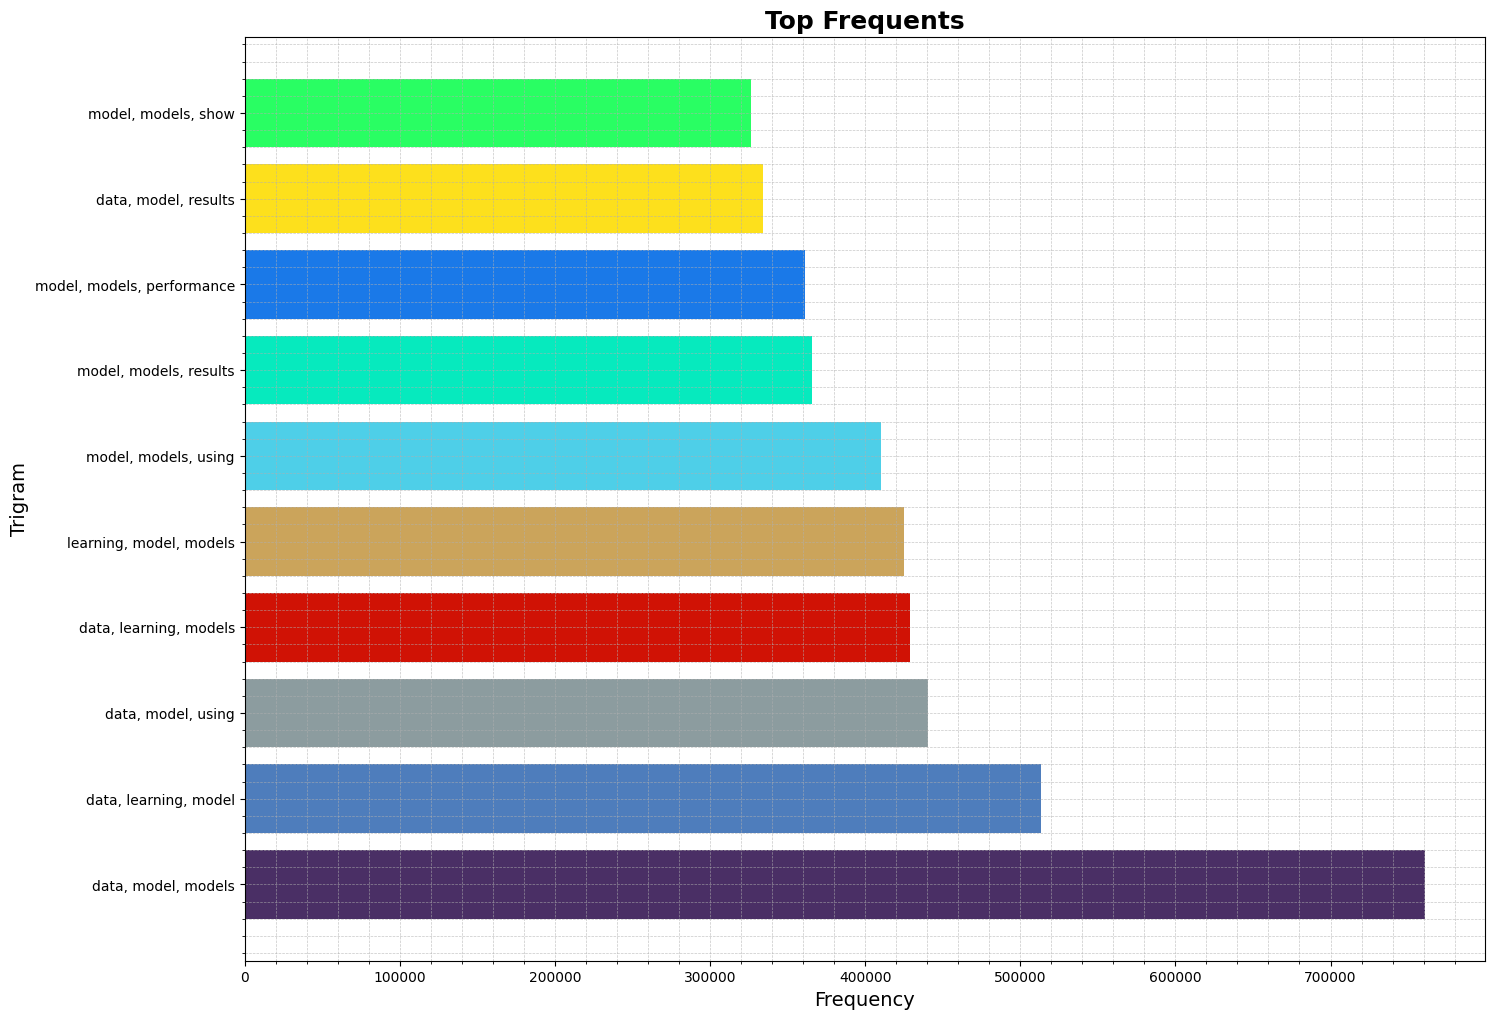

In [63]:
top_k = 10
top_frequent_triples = sorted_triples_by_frequency[:top_k]

labels = [", ".join(triple) for triple, _ in top_frequent_triples]
values = [count for _, count in top_frequent_triples]

colors = [f"#{''.join([random.choice('0123456789ABCDEF') for _ in range(6)])}" for _ in sorted_frequent_triples]

plt.figure(figsize=(16, 12))
plt.barh(labels, values, color=colors)  
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Trigram", fontsize=14)
plt.title("Top Frequents", fontsize=18, fontweight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.minorticks_on()
plt.show()


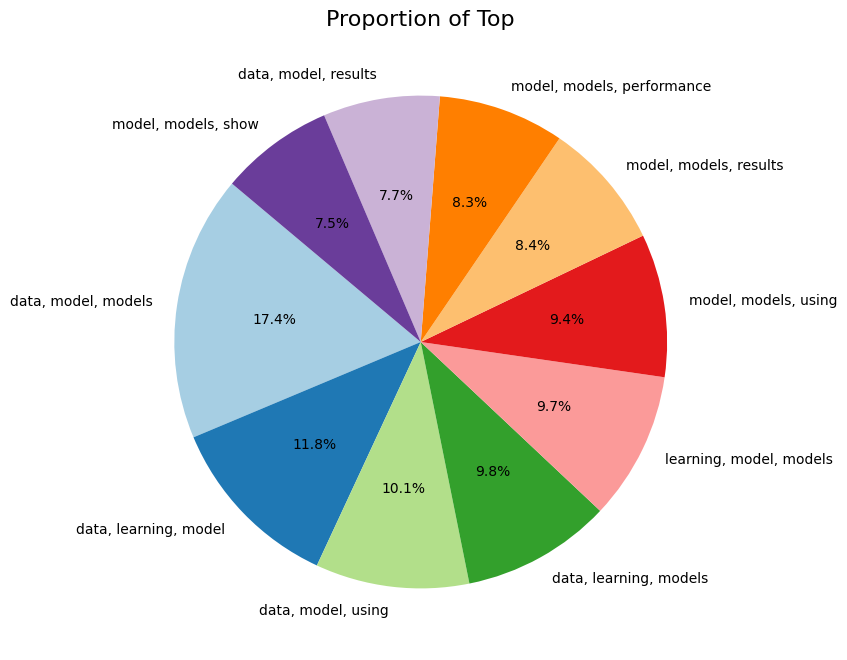

In [61]:
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Proportion of Top", fontsize=16)
plt.show()


#### **PCY - New**

##### Code

In [14]:
tokenized_rdd = cleaned_rdd.map(lambda record: record["abstract"].split())

# bucket_size_pair = 2000
# bucket_size_triple = 5000

bucket_size_pair = 60000
bucket_size_triple = 250000

# threshold_singletons = 200000
# threshold_pairs = 150000
# threshold_triples = 50000

threshold_singletons = 250000
threshold_pairs = 200000
threshold_triples = 70000

def hash_pair(pair):
    return int(hashlib.md5("_".join(sorted(pair)).encode()).hexdigest(), 16) % bucket_size_pair

def hash_triple(triple):
    return int(hashlib.md5("_".join(sorted(triple)).encode()).hexdigest(), 16) % bucket_size_triple

# Frequent Singletones
singleton_counts = tokenized_rdd.flatMap(lambda transaction: [(item, 1) for item in transaction]) \
    .reduceByKey(lambda x, y: x + y)

frequent_singletons = singleton_counts.filter(lambda x: x[1] >= threshold_singletons).map(lambda x: x[0]).collect()
frequent_singletons_broadcast = sc.broadcast(frequent_singletons)

# Frequent Pairs
buckets_pairs = (tokenized_rdd.map(lambda transaction: [word for word in transaction if word in frequent_singletons_broadcast.value if len(transaction)>=2])
                .flatMap(lambda frequent_words: [(hash_pair(pair), 1) for pair in combinations(frequent_words, 2) if pair[0] != pair[1]])
                .reduceByKey(lambda x, y: x + y))

bitmap_pairs = (buckets_pairs.filter(lambda x: x[1] >= threshold_pairs).map(lambda x: x[0]).collect())
bitmap_pairs_broadcast = sc.broadcast(bitmap_pairs)

frequent_pairs = (tokenized_rdd.map(lambda transaction: [word for word in transaction if word in frequent_singletons_broadcast.value])
                .flatMap(lambda frequent_words: [(pair, 1) for pair in combinations(sorted(frequent_words), 2) if len(set(pair)) ==2 and hash_pair(pair) in bitmap_pairs_broadcast.value])
                .reduceByKey(lambda x, y: x + y) \
                .filter(lambda x: x[1] >= threshold_pairs).map(lambda x: x[0]))

pairs_frequent = frequent_pairs.collect()

top_frequent_pairs =sc.broadcast(pairs_frequent)


In [18]:
frequent_singletons

['field',
 'methods',
 'model',
 'result',
 'distribution',
 'time',
 'performance',
 'structure',
 'study',
 'problem',
 'framework',
 'may',
 'set',
 'magnetic',
 'analysis',
 'different',
 'due',
 'also',
 'based',
 'paper',
 'theory',
 'however',
 'network',
 'large',
 'density',
 'using',
 'mass',
 'proposed',
 'potential',
 'approach',
 'learning',
 'data',
 'order',
 'show',
 'phase',
 'function',
 'first',
 'find',
 'high',
 'energy',
 'work',
 'number',
 'parameters',
 'algorithm',
 'results',
 'models',
 'properties',
 'present',
 'propose',
 'states',
 'obtained',
 'one',
 'systems',
 'general',
 'two',
 'case',
 'system',
 'information',
 'quantum',
 'demonstrate',
 'given',
 'space',
 'new',
 'method',
 'well',
 'observed',
 'used',
 'provide',
 'use',
 'functions',
 'state']

In [19]:
frequents_singletons = singleton_counts.filter(lambda x: x[1] >= threshold_singletons).collect()
frequents_singletons

[('field', 544587),
 ('methods', 403586),
 ('model', 1188676),
 ('result', 259625),
 ('distribution', 285328),
 ('time', 506071),
 ('performance', 361302),
 ('structure', 338164),
 ('study', 596891),
 ('problem', 469942),
 ('framework', 276989),
 ('may', 270973),
 ('set', 305096),
 ('magnetic', 314065),
 ('analysis', 387626),
 ('different', 497350),
 ('due', 279395),
 ('also', 774216),
 ('based', 527532),
 ('paper', 650231),
 ('theory', 453815),
 ('however', 341106),
 ('network', 319688),
 ('large', 419045),
 ('density', 281309),
 ('using', 809828),
 ('mass', 339069),
 ('proposed', 400548),
 ('potential', 258792),
 ('approach', 455051),
 ('learning', 402196),
 ('data', 917131),
 ('order', 359236),
 ('show', 831879),
 ('phase', 331058),
 ('function', 384680),
 ('first', 412330),
 ('find', 383460),
 ('high', 323680),
 ('energy', 473226),
 ('work', 366284),
 ('number', 412588),
 ('parameters', 269949),
 ('algorithm', 314087),
 ('results', 859049),
 ('models', 686537),
 ('properties', 3629

In [20]:
pairs_frequent

[('different', 'model'),
 ('learning', 'methods'),
 ('different', 'models'),
 ('approach', 'using'),
 ('first', 'model'),
 ('models', 'results'),
 ('model', 'network'),
 ('paper', 'results'),
 ('results', 'study'),
 ('based', 'model'),
 ('data', 'new'),
 ('data', 'model'),
 ('methods', 'model'),
 ('model', 'phase'),
 ('based', 'data'),
 ('data', 'propose'),
 ('model', 'well'),
 ('data', 'results'),
 ('also', 'new'),
 ('mass', 'model'),
 ('model', 'systems'),
 ('based', 'using'),
 ('system', 'systems'),
 ('model', 'paper'),
 ('model', 'present'),
 ('also', 'show'),
 ('one', 'two'),
 ('data', 'different'),
 ('approach', 'data'),
 ('method', 'proposed'),
 ('models', 'paper'),
 ('model', 'system'),
 ('model', 'parameters'),
 ('large', 'model'),
 ('state', 'states'),
 ('method', 'results'),
 ('system', 'using'),
 ('method', 'methods'),
 ('models', 'performance'),
 ('model', 'models'),
 ('method', 'show'),
 ('data', 'use'),
 ('data', 'information'),
 ('data', 'show'),
 ('also', 'models'),
 (

In [21]:

frequents_pairs = (tokenized_rdd.map(lambda transaction: [word for word in transaction if word in frequent_singletons_broadcast.value])
                .flatMap(lambda frequent_words: [(pair, 1) for pair in combinations(sorted(frequent_words), 2) if len(set(pair)) ==2 and hash_pair(pair) in bitmap_pairs_broadcast.value])
                .reduceByKey(lambda x, y: x + y) \
                .filter(lambda x: x[1] >= threshold_pairs))

frequents_pairs = frequents_pairs.collect()
frequents_pairs

[(('different', 'model'), 315530),
 (('learning', 'methods'), 233098),
 (('different', 'models'), 222661),
 (('approach', 'using'), 225629),
 (('first', 'model'), 218613),
 (('models', 'results'), 282817),
 (('model', 'network'), 239497),
 (('paper', 'results'), 260331),
 (('results', 'study'), 237934),
 (('based', 'model'), 347733),
 (('data', 'new'), 278357),
 (('data', 'model'), 732441),
 (('methods', 'model'), 256957),
 (('model', 'phase'), 210695),
 (('based', 'data'), 300947),
 (('data', 'propose'), 233233),
 (('model', 'well'), 209987),
 (('data', 'results'), 387518),
 (('also', 'new'), 202725),
 (('mass', 'model'), 210256),
 (('model', 'systems'), 218380),
 (('based', 'using'), 215411),
 (('system', 'systems'), 322612),
 (('model', 'paper'), 325402),
 (('model', 'present'), 250234),
 (('also', 'show'), 329963),
 (('one', 'two'), 275212),
 (('data', 'different'), 274554),
 (('approach', 'data'), 285386),
 (('method', 'proposed'), 280215),
 (('models', 'paper'), 206173),
 (('mode

In [25]:
print(f"Frequent Pairs: {len(frequents_pairs)}")

Frequent Pairs: 134


In [17]:
# Frequent triples
buckets_triples = (tokenized_rdd.map(lambda transaction: [word for word in transaction if word in frequent_singletons_broadcast.value])
                  .flatMap(lambda frequent_words: [(hash_triple(triple), 1) for triple in combinations(sorted(frequent_words), 3) if len(set(triple)) ==3
                  and all(tuple(sorted(pair)) in top_frequent_pairs.value for pair in combinations(triple, 2))])
                  .reduceByKey(lambda x, y: x + y))

bitmap_triples = (buckets_triples.filter(lambda x: x[1] >= threshold_triples).map(lambda x: x[0]).collect())
bitmap_triples_broadcast = sc.broadcast(bitmap_triples)

frequent_triples = (tokenized_rdd.map(lambda transaction: [word for word in transaction if word in frequent_singletons_broadcast.value])
                  .flatMap(lambda frequent_words: [triple for triple in combinations(sorted(frequent_words), 3) if len(set(triple)) ==3
                  and all(tuple(sorted(pair)) in top_frequent_pairs.value for pair in combinations(triple, 2))
                  and hash_triple(triple) in bitmap_triples_broadcast.value]).map(lambda triple: (tuple(sorted(triple)), 1))
                  .reduceByKey(lambda x, y: x + y)
                  .filter(lambda x: x[1] >= threshold_triples))

top_frequent_triples = frequent_triples.collect()

for triplet, count in top_frequent_triples:
    print(f"{triplet}: {count}") 

('based', 'method', 'model'): 158151
('models', 'paper', 'results'): 94586
('approach', 'data', 'model'): 275625
('data', 'method', 'proposed'): 223448
('results', 'show', 'using'): 151915
('data', 'model', 'system'): 145738
('model', 'results', 'using'): 240350
('data', 'model', 'new'): 234546
('data', 'paper', 'problem'): 95805
('model', 'models', 'performance'): 361502
('different', 'two', 'using'): 97845
('different', 'results', 'using'): 110446
('based', 'results', 'using'): 109343
('model', 'quantum', 'system'): 88221
('data', 'used', 'using'): 179294
('data', 'show', 'study'): 70213
('model', 'models', 'results'): 365699
('data', 'new', 'results'): 120780
('also', 'paper', 'results'): 101969
('data', 'learning', 'performance'): 290776
('based', 'model', 'results'): 169185
('data', 'models', 'paper'): 177701
('data', 'learning', 'methods'): 302479
('also', 'model', 'new'): 120927
('model', 'paper', 'show'): 123359
('model', 'show', 'using'): 190176
('model', 'problem', 'show'): 1

#### **Jaccard**

In [36]:
apriori_results = frequent_triples.map(lambda x: x[0]).collect()

In [29]:
pcy_results = frequent_triples.map(lambda x: x[0]).collect()

In [1]:
pcy_frequent_trigrams = set(pcy_results)  
apriori_frequent_trigrams = set(apriori_results)  

# True Positives (TP), False Positives (FP), and False Negatives (FN)
true_positives = pcy_frequent_trigrams.intersection(apriori_frequent_trigrams)
false_positives = pcy_frequent_trigrams - apriori_frequent_trigrams
false_negatives = apriori_frequent_trigrams - pcy_frequent_trigrams

# Jaccard Calculation
jaccard_index = len(true_positives) / len(pcy_frequent_trigrams.union(apriori_frequent_trigrams))

print(f"True Positives (TP): {len(true_positives)}")
print(f"False Positives (FP): {len(false_positives)}")
print(f"False Negatives (FN): {len(false_negatives)}")
print(f"Jaccard Index: {jaccard_index:.4f}")


True Positives (TP): 103
False Positives (FP): 7
False Negatives (FN): 81
Jaccard Index: 0.5393


---
 *Second Jaccard*

In [46]:
apriori_results = frequent_triples.map(lambda x: x[0]).collect()
len(set(apriori_results))

191

In [47]:
pcy_frequent_trigrams = set(pcy_results)  
apriori_frequent_trigrams = set(apriori_results)  

# True Positives (TP), False Positives (FP), and False Negatives (FN)
true_positives = pcy_frequent_trigrams.intersection(apriori_frequent_trigrams)
false_positives = pcy_frequent_trigrams - apriori_frequent_trigrams
false_negatives = apriori_frequent_trigrams - pcy_frequent_trigrams

# Jaccard Calculation
jaccard_index = len(true_positives) / len(pcy_frequent_trigrams.union(apriori_frequent_trigrams))

print(f"True Positives (TP): {len(true_positives)}")
print(f"False Positives (FP): {len(false_positives)}")
print(f"False Negatives (FN): {len(false_negatives)}")
print(f"Jaccard Index: {jaccard_index:.4f}")


True Positives (TP): 191
False Positives (FP): 0
False Negatives (FN): 0
Jaccard Index: 1.0000
